In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import warnings
#warnings.filterwarnings("ignore")

<b>Plan :</b>

- prepare data (remove outlier) peut être le faire en EDA.
- splitting in origin train and test set.
- resampled origin et split it in train et valid set (only for simple prediction not for cross or tune).
- first prediction on validation set.
- fine tuning. (origin train set)
- cross validation. (origin train set)
- testing.
- Deep learning à la fin?

<b>Choses à faire:</b>

- Ajouter barplot pour comparer les modèles.
- Expliquer pourquoi on undersample et oversample ( le papier).
- Expliquer pourquoi resample durant la cross validation.
- Ajouter normalisation !
- Faire grid search cv avec pipeline??

In [2]:
df_origin_train =  pd.read_csv('/Users/lucas/Desktop/DS_project/credit_fraud/train_set.csv')
df_test =  pd.read_csv('/Users/lucas/Desktop/DS_project/credit_fraud/test_set.csv')

In [3]:
X_origin_train = df_origin_train.drop(columns=['Class'])
y_origin_train = df_origin_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [4]:
from sklearn.model_selection import train_test_split
# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, learning_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Le défi de travailler avec des ensembles de données déséquilibrés (Imbalanced) est que la plupart des techniques de ML ignoreront la (ou les) classe minoriaire, et auront à leur tour des performances médiocres sur la (ou les) classe minoritaire, bien que ce soit généralement la performance sur la classe minoritaire qui soit la plus importante.

Une approche pour traiter les ensembles de données déséquilibrés consiste à suréchantillonner (oversample) la (ou les) classe(s) minoritaire(s):
- L’approche la plus simple consiste à dupliquer des exemples dans la classe minoritaire, bien que ces exemples n’ajoutent aucune nouvelle information au modèle.
- Au lieu de cela, de nouveaux exemples peuvent être synthétisés à partir des exemples existants. Il s'agit d'un type d'augmentation des données pour la (les) classe(s) minoritaire(s) et est appelé Synthetic Minority Oversampling TEchnique, ou SMOTE en abrégé.


- Comment marche SMOTE?
    - SMOTE fonctionne en sélectionnant des exemples qui sont proches dans l'espace des variables, en traçant une ligne entre les exemples dans l'espace des variables et en dessinant un nouvel échantillon à un point le long de cette ligne.
    - Plus précisément, un exemple aléatoire de la classe minoritaire est d'abord choisi. On trouve alors k des voisins les plus proches. Un voisin sélectionné au hasard est choisi et un exemple synthétique est créé à un point sélectionné au hasard entre les deux exemples dans l'espace des variables.

- Cette procédure peut être utilisée pour créer autant d'exemples synthétiques pour la classe minoritaire que nécessaire. Comme décrit dans l'article, il suggère d'utiliser d'abord le sous-échantillonnage aléatoire (random undersampling) pour réduire le nombre d'exemples dans la classe majoritaire, puis d'utiliser SMOTE pour suréchantillonner la classe minoritaire afin d'équilibrer la distribution de classe.

- On pourrait penser qu'il suffit d'effectuer ces méthodes sur le dataset une fois, avant de l'utiliser dans nos modèle. Cependant, ce n'est pas ce que nous allons faire, car cela peut poser énormément de problème notamment lors de la validation. Nous allons expliquer notre méthodologie en utilisant SMOTE au fur et à mesure.

In [5]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)

X_train_resampled, y_train_resampled = over.fit_sample(X_origin_train, y_origin_train)
X_train_resampled, y_train_resampled = under.fit_sample(X_train_resampled, y_train_resampled)


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [7]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBoost":XGBClassifier()
}

In [8]:
models = []
train_scores = []
valid_scores = []
valid_precision_scores = []
valid_recall_scores = []

In [9]:
for key, classifier in classifiers.items():
    print('training with ' + key + ' ...')
   
    classifier.fit(X_train, y_train)
    
    models.append(key)
    train_scores.append(classifier.score(X_train, y_train))
    
    y_pred = classifier.predict(X_valid)

    valid_scores.append(accuracy_score(y_pred, y_valid))
    valid_precision_scores.append(precision_score(y_valid, y_pred))
    valid_recall_scores.append(recall_score(y_valid, y_pred))
    
    

training with RandomForest ...
training with LogisticRegression ...
training with DecisionTreeClassifier ...
training with XGBoost ...


In [10]:
results = pd.DataFrame(data={'model':models, 'training score':train_scores,
                             'validation accuracy':valid_scores,
                             'validation precision':valid_precision_scores,
                            'validation recall':valid_recall_scores})
results

,model,training score,validation accuracy,validation precision,validation recall
0,RandomForest,1.000000,0.998305,0.997687,0.997687
1,LogisticRegression,0.942023,0.942978,0.970611,0.870722
2,DecisionTreeClassifier,1.000000,0.992417,0.987565,0.991790
3,XGBoost,0.966785,0.963736,0.980869,0.918941


- faire des barplots

<br>
<b>fine tuning</b>

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:

params_classifiers = {
    "RandomForest": [{'bootstrap':[False,True],'n_estimators':range(50,150,20),'max_depth':range(1,6,1),
               'max_features':['auto','sqrt','log2']}],
    
    "DecisionTreeClassifier": [{'criterion':['gini','entropy'],'splitter':['best', 'random'],'max_depth':range(1,6,1),
               'max_features':['auto','sqrt','log2']}],
    
    "LogisticRegression": [{'max_iter':range(100,500,100),'C': [ 0.1, 1, 10]}],
    "XGBoost": [{'max_depth': range(1,6,1),'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}]
    
}



In [13]:
estimators = []
best_estimators = []
best_scores = []
for key, classifier in classifiers.items():
    print(key + ' tuning...')
    estimators.append(key)
    
    grid = GridSearchCV(classifier, params_classifiers[key], scoring = 'balanced_accuracy')
    grid.fit(X_train_resampled, y_train_resampled)
    
    best_estimators.append(grid.best_estimator_)
    best_scores.append(grid.best_score_)

RandomForest tuning...
LogisticRegression tuning...
DecisionTreeClassifier tuning...
XGBoost tuning...


In [14]:
tuning = pd.DataFrame(data={'model':estimators, 'best estimator':best_estimators,
                             'best score':best_scores})
tuning

,model,best estimator,best score
0,RandomForest,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.936723
1,LogisticRegression,LogisticRegression(C=0.1),0.928578
2,DecisionTreeClassifier,"DecisionTreeClassifier(max_depth=5, max_featur...",0.932616
3,XGBoost,"XGBClassifier(max_depth=5, n_estimators=180)",0.991782


- cross-validation

In [18]:
all_scores = []
for estim in best_estimators:
    pipeline = imbalanced_make_pipeline(over, under, estim)
    all_scores.append(cross_val_score(pipeline, X_origin_train, y_origin_train, cv=5, scoring='balanced_accuracy'))

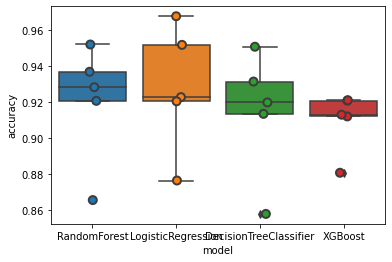

In [19]:
entries = []
for i in range(0, len(all_scores)):
    for score in all_scores[i]:
        entries.append((models[i], score))
        
cv_df = pd.DataFrame(entries, columns=['model','accuracy'])

    
sns.boxplot(x='model', y='accuracy', data=cv_df)
sns.stripplot(x='model', y='accuracy', data=cv_df, 
                          size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

- testing

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.89      0.47        98

    accuracy                           1.00     56962
   macro avg       0.66      0.94      0.73     56962
weighted avg       1.00      1.00      1.00     56962



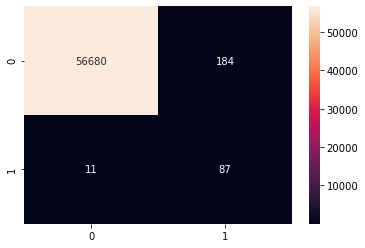

------------------------------
LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



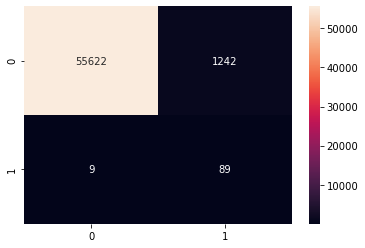

------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.89      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.92      0.53     56962
weighted avg       1.00      0.96      0.98     56962



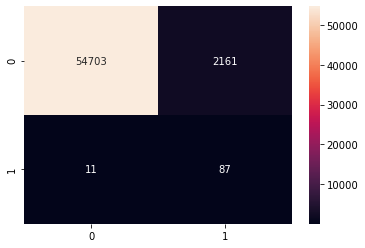

------------------------------
XGBClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.89      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.67     56962
weighted avg       1.00      0.99      1.00     56962



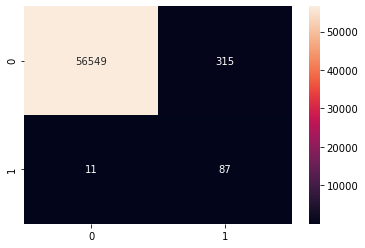

------------------------------


In [20]:

for estim in best_estimators:
    print(estim.__class__.__name__)
    pipeline = imbalanced_make_pipeline(over, under, estim)
    pipeline.fit(X_origin_train, y_origin_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    conf = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf,annot=True,fmt='2.0f')
    plt.show()
    print('-'*30)
    
    